# Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pet_cli.tcms_as_convolutions as pet_tcm
import pet_cli.reference_tissue_models as pet_rtms
from importlib import reload

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.6)
plt.rcParams['font.family'] ='StixGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

# Simplified Reference Tissue Model (SRTM)

The analytical solution for the SRTM describes the tissue TAC, $C(t)$, as a function of a reference TAC, $C_\mathrm{R}(t)$, is:
$$
C(t) = R_{1} C_\mathrm{R}(t) + \left( k_{2} - \frac{R_{1}k_{2}}{1+\mathrm{BP_\mathrm{ND}}} \right) C_\mathrm{R}(t)\otimes \exp\left[-\frac{k_{2}}{1+\mathrm{BP_\mathrm{ND}}} t\right].
$$
By defining $\alpha\equiv\frac{k_{2}}{1+\mathrm{BP_\mathrm{ND}}}$, we can rewrite the equation as:
$$
C(t) = R_{1} C_\mathrm{R}(t) + \left( k_{2} - R_{1}\alpha\right) C_\mathrm{R}(t)\otimes \exp\left[-\alpha \cdot t\right].
$$

## Loading An Input Function

In [2]:
input_tac_times, input_tac_vals = np.asarray(np.loadtxt("../../data/tcm_tacs/fdg_plasma_clamp_evenly_resampled.txt").T, float)
input_tac_times /= 60.0 #Converting from minutes to seconds


## Generating An Example Reference Region
We use a 1TCM with $K_1=0.5$ and $k_2=2.0$.

In [3]:
ref_tac_times, ref_tac_vals  = pet_tcm.generate_tac_1tcm_c1_from_tac(tac_times=input_tac_times,
                                                                     tac_vals=input_tac_vals,
                                                                     k1=0.5, 
                                                                     k2=2.0)

### Example SRTM TAC
We use $R_1=0.5$, $k_2=1.0$ and $BP=3.0$.

In [4]:
srtm_test_params = np.asarray((0.5, 1.0, 3.0))
srtm_tac_vals = pet_rtms.calc_srtm_tac(tac_times=ref_tac_times, 
                                      ref_tac_vals=ref_tac_vals, 
                                      r1=srtm_test_params[0], 
                                      k2=srtm_test_params[1], 
                                      bp=srtm_test_params[2])

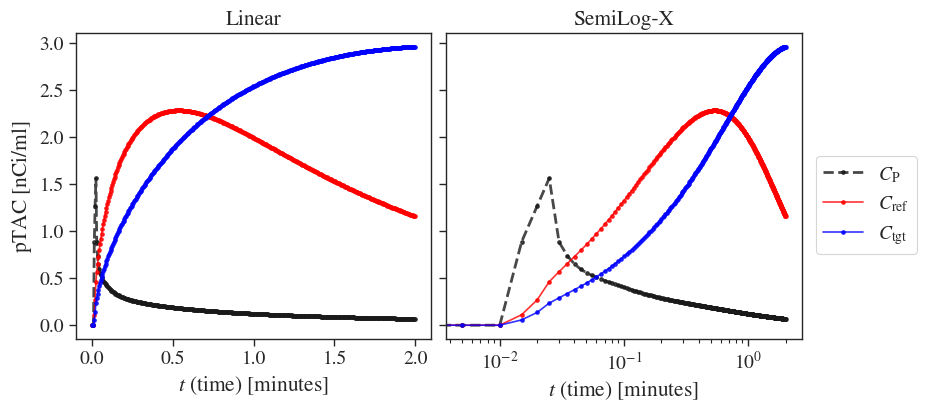

In [5]:
myFig, myAx = plt.subplots(1,2, constrained_layout=True, figsize=[8,4], sharey=True)
for anAx in myAx.flatten():
    anAx.plot(input_tac_times, input_tac_vals/50., '.--', alpha=0.8, color='k', label=r'$C_\mathrm{P}$', lw=2)
    anAx.plot(ref_tac_times, ref_tac_vals, '.-', alpha=0.8, color='red', label=r'$C_\mathrm{ref}$')
    anAx.plot(ref_tac_times, srtm_tac_vals, '.-', alpha=0.8, color='blue', label=r'$C_\mathrm{tgt}$')
    anAx.set(xlabel=r'$t$ (time) [minutes]')
myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear')
myAx[1].set(xscale='log', title='SemiLog-X')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left')
plt.show()

## Looping Over Multiple Parameters

In [198]:
def add_gaussian_noise_to_tac(tac_vals: np.ndarray, scale: float =0.2) -> np.ndarray:
    noise = np.random.normal(loc=0.0, scale=scale, size=tac_vals.shape)
    tac_out = tac_vals + noise
    tac_out[0] = 0.0
    return tac_out

def add_gaussian_noise_to_tac_based_on_max(tac_vals: np.ndarray, scale: float = 0.05) -> np.ndarray:
    noise = np.random.normal(loc=0.0, scale=np.max(tac_vals)*scale, size=tac_vals.shape)
    tac_out = tac_vals + noise
    tac_out[0] = 0.0
    return tac_out

In [199]:
num_samples = 5
r1_params = np.random.random(num_samples)*10.0 + 0.001
k2_params = np.random.random(num_samples)*10.0 + 0.001
bp_params = np.random.random(num_samples)*10.0 + 0.001

srtm_test_params = np.vstack([r1_params, k2_params, bp_params]).T

srtm_test_params

array([[9.97674268, 9.84757029, 0.57519091],
       [8.21995945, 3.27446625, 6.87955293],
       [1.78694788, 8.57952641, 7.70200111],
       [7.47955834, 8.7426967 , 7.00173167],
       [6.68602935, 1.81812854, 4.86308404]])

In [200]:
reload(pet_rtms)
def calc_diff(real_answer, new_answer):
    diff = new_answer - real_answer
    per_d = diff / real_answer * 100.
    
    return new_answer, diff, per_d

def print_arrs(pre_str:str, *args):
    print(f"{pre_str+':':<8}", end=' ')
    for an_arr in args:
        str_arr = [f"{a_num:<5.2f}" for a_num in an_arr]
        print(f"({', '.join(str_arr)})", end='; ')
    print()
# print(calc_diff(test_params[0], pOpt))
print_arrs("pOpt", *calc_diff(srtm_test_params[0], pOpt))

pOpt:    (0.11 , 6.50 , 2.83 ); (-9.86, -3.35, 2.26 ); (-98.86, -34.04, 392.73); 


--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (9.98 , 9.85 , 0.58 ); 
pOpt:    (9.97 , 9.93 , 0.59 ); (-0.00, 0.08 , 0.01 ); (-0.03, 0.82 , 2.43 ); 


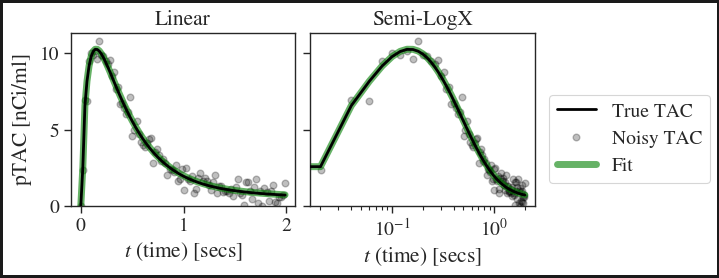

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (8.22 , 3.27 , 6.88 ); 
pOpt:    (8.23 , 8.47 , 6.97 ); (0.01 , 5.19 , 0.09 ); (0.10 , 158.59, 1.33 ); 


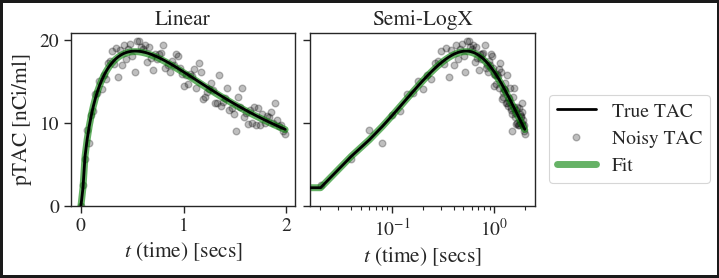

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (1.79 , 8.58 , 7.70 ); 
pOpt:    (1.75 , 8.88 , 7.59 ); (-0.04, 0.30 , -0.12); (-2.34, 3.53 , -1.51); 


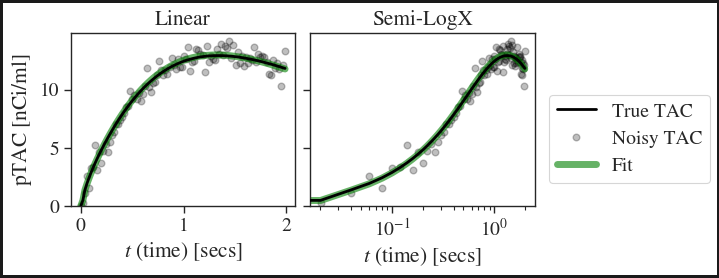

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (7.48 , 8.74 , 7.00 ); 
pOpt:    (7.47 , 8.97 , 6.96 ); (-0.01, 0.23 , -0.05); (-0.14, 2.62 , -0.64); 


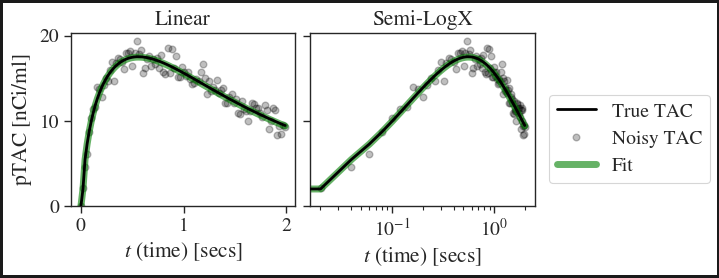

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (6.69 , 1.82 , 4.86 ); 
pOpt:    (6.72 , 0.04 , 0.00 ); (0.04 , -1.78, -4.86); (0.56 , -98.03, -100.00); 


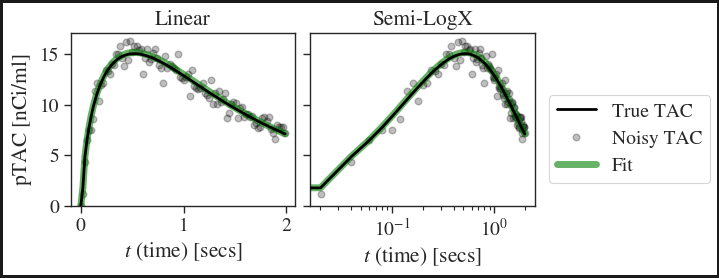

In [201]:
stride = 4
model_func = pet_rtms.calc_srtm_tac
for tID, t_params in enumerate(srtm_test_params[:]):
    rtm_tac_vals = model_func(ref_tac_times, *t_params, ref_tac_vals)
    if np.min(rtm_tac_vals) < 0:
        continue
    print('-' * 80)
    print(f"{'Value':<30};{'Diff':<22};{'%Diff':<32}")

    noisy_tgt_vals = add_gaussian_noise_to_tac_based_on_max(rtm_tac_vals)
    
    pOpt, pCor = pet_rtms.fit_srtm_to_tac_with_bounds(tgt_tac_vals=noisy_tgt_vals, 
                                                      ref_tac_times=ref_tac_times,
                                                      ref_tac_vals=ref_tac_vals,
                                                      r1_bounds=(1.0, 0.0001, 10.0),
                                                      k2_bounds=(1.0, 0.0001, 10.0), 
                                                      bp_bounds=(1.0, 0.0001, 10.0))
    print_arrs("Actual", t_params)
    print_arrs("pOpt", *calc_diff(t_params, pOpt))
    
    myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8/1.5, 4/1.5], sharey=True, linewidth=3.0, edgecolor='k')
    for anAx in myAx.flatten():
        anAx.plot(ref_tac_times[::stride], rtm_tac_vals[::stride], '-', alpha=1.0, color='black',
                  label=r'True TAC', lw=2.0, zorder=4)
        anAx.plot(ref_tac_times[::stride], noisy_tgt_vals[::stride], 'o', alpha=0.25, color='black',
                  label=r'Noisy TAC')
        yAr = model_func(ref_tac_times, *pOpt, ref_tac_vals)
        anAx.plot(ref_tac_times[::stride], yAr[::stride], '-', alpha=0.6, color='green', lw=5, label='Fit')
    
    leg_hands, leg_labs = list(myAx[0].get_legend_handles_labels())
    
    myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear', ylim=(-0.25, None), xlabel='$t$ (time) [secs]')
    myAx[1].set(xscale='log', ylim=(-0.0001, None), title='Semi-LogX', xlabel='$t$ (time) [secs]')
    
    myFig.legend(leg_hands, leg_labs, bbox_to_anchor=(1.0, 0.5), loc='center left')
    plt.show()


## Generating A Large Number Of Fits And Generating A Simple Scatter Plot Of Fit vs. Real

### Unbounded Fits

In [211]:
num_samples = 500
r1_params = np.random.random(num_samples)*5.0  + 0.001
k2_params = np.random.random(num_samples)*10.0 + 0.001
bp_params = np.random.random(num_samples)*10.0 + 0.001
srtm_test_params_large = np.vstack([r1_params, k2_params, bp_params]).T

model_func = pet_rtms.calc_srtm_tac
srtm_fit_params = np.zeros_like(srtm_test_params_large)
for tID, t_params in enumerate(srtm_test_params[:]):
    rtm_tac_vals = model_func(ref_tac_times, *t_params, ref_tac_vals)
    noisy_tgt_vals = add_gaussian_noise_to_tac_based_on_max(rtm_tac_vals)
    pOpt, pCor = pet_rtms.fit_srtm_to_tac(tgt_tac_vals=noisy_tgt_vals, 
                                          ref_tac_times=ref_tac_times,
                                          ref_tac_vals=ref_tac_vals)
    srtm_fit_params[tID] = pOpt[:]

/Users/furqandar/Library/Python/3.9/lib/python/site-packages/pet_cli/reference_tissue_models.py:47: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(-bp_coeff * tac_times)


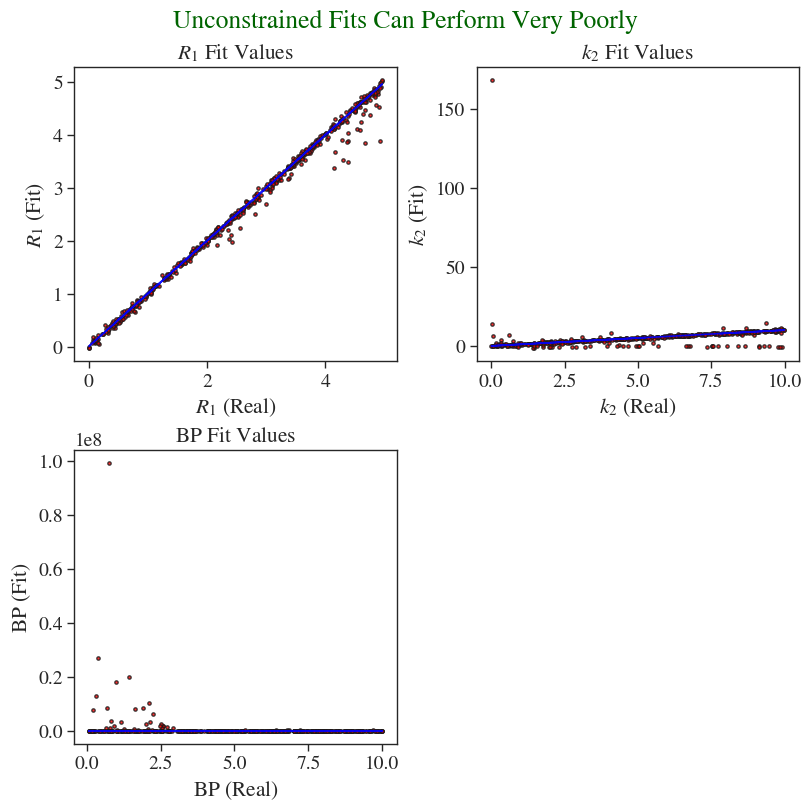

In [218]:
srtm_param_names = [r'$R_1$', r'$k_2$', r'$\mathrm{BP}$']
myFig, myAx = plt.subplots(2,2, figsize=[8,8], constrained_layout=True)
fAx = myAx.flatten()
for pID, param in enumerate(srtm_param_names):
    fAx[pID].set_title(f"{param} Fit Values")
    fAx[pID].plot(srtm_test_params[:,pID], srtm_fit_params[:,pID], '.', 
                     alpha=0.8, color='red', mec='k')
    fAx[pID].plot(srtm_test_params[:,pID], srtm_test_params[:,pID], '-', 
                     alpha=0.9, color='blue', mec='k')
    fAx[pID].set(xlabel=fr'{param} (Real)', ylabel=fr'{param} (Fit)')
fAx[-1].axis('off')
myFig.suptitle("Unconstrained Fits Can Perform Very Poorly", color='darkgreen')
plt.show()

### Bounded Fits

In [209]:
num_samples = 500
r1_params = np.random.random(num_samples)*5.0  + 0.001
k2_params = np.random.random(num_samples)*10.0 + 0.001
bp_params = np.random.random(num_samples)*10.0 + 0.001
srtm_test_params_large = np.vstack([r1_params, k2_params, bp_params]).T

model_func = pet_rtms.calc_srtm_tac
srtm_fit_params = np.zeros_like(srtm_test_params_large)
for tID, t_params in enumerate(srtm_test_params[:]):
    rtm_tac_vals = model_func(ref_tac_times, *t_params, ref_tac_vals)
    noisy_tgt_vals = add_gaussian_noise_to_tac_based_on_max(rtm_tac_vals)
    pOpt, pCor = pet_rtms.fit_srtm_to_tac_with_bounds(tgt_tac_vals=noisy_tgt_vals, 
                                                      ref_tac_times=ref_tac_times,
                                                      ref_tac_vals=ref_tac_vals,
                                                      r1_bounds=(1.0, 0.0001, 10.0),
                                                      k2_bounds=(1.0, 0.0001, 10.0), 
                                                      bp_bounds=(1.0, 0.0001, 10.0))
    srtm_fit_params[tID] = pOpt[:]

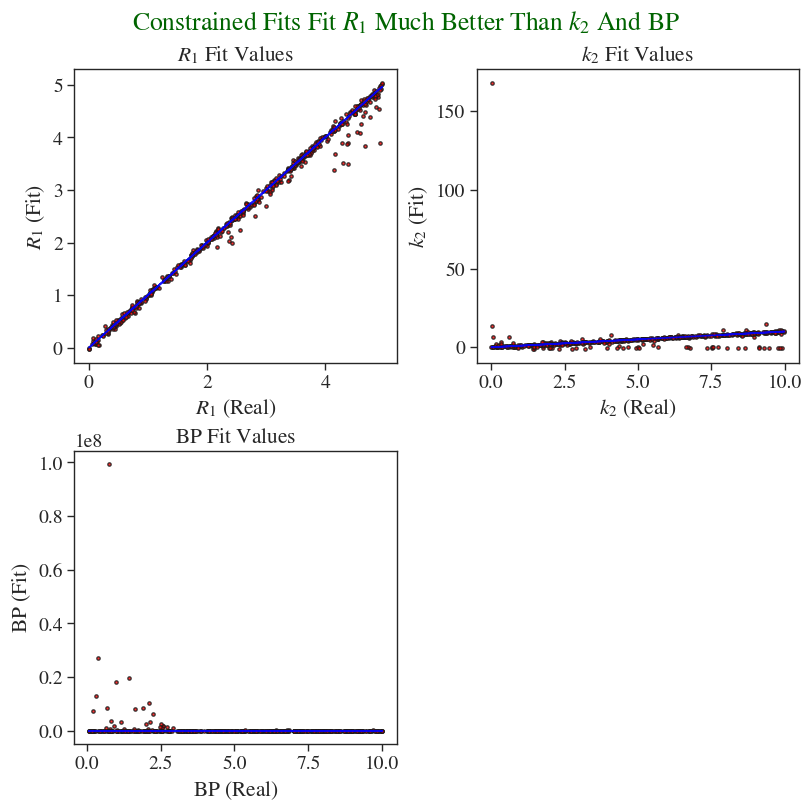

In [217]:
srtm_param_names = [r'$R_1$', r'$k_2$', r'$\mathrm{BP}$']
myFig, myAx = plt.subplots(2,2, figsize=[8,8], constrained_layout=True)
fAx = myAx.flatten()
for pID, param in enumerate(srtm_param_names):
    fAx[pID].set_title(f"{param} Fit Values")
    fAx[pID].plot(srtm_test_params[:,pID], srtm_fit_params[:,pID], '.', 
                     alpha=0.8, color='red', mec='k')
    fAx[pID].plot(srtm_test_params[:,pID], srtm_test_params[:,pID], '-', 
                     alpha=0.9, color='blue', mec='k')
    fAx[pID].set(xlabel=fr'{param} (Real)', ylabel=fr'{param} (Fit)')
fAx[-1].axis('off')
myFig.suptitle("Constrained Fits Fit $R_1$ Much Better Than $k_2$ And $\mathrm{BP}$", color='darkgreen')
plt.show()